# LOADEING DATA AND THE INTINTIAL PREPROCESSING

In [2]:
import os
from PIL import Image
import numpy as np

def load_raw_images_from_directory(data_dir, allowed_formats=None):

    if allowed_formats is None:
        allowed_formats = {'jpg', 'jpeg', 'png', 'tif', 'bmp'}  # Default supported formats

    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Get sorted class names from folders
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):  # Check if it is a directory
            for img_file in os.listdir(class_path):
                # Check file extension
                if img_file.split('.')[-1].lower() not in allowed_formats:
                    continue  # Skip unsupported formats

                img_path = os.path.join(class_path, img_file)
                try:
                    # Use 'with' to load and close the file automatically
                    with Image.open(img_path) as img:
                        images.append(img.convert("L"))  # Convert to grayscale
                        labels.append(class_name)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return images, labels, class_names

# Set directories
train_dir = r"split_dataset\train"
test_dir = r"split_dataset\test"
valid_dir = r"split_dataset\valid"

# Load raw data (without preprocessing)
train_images_raw, train_labels, train_class_names = load_raw_images_from_directory(train_dir)
test_images_raw, test_labels, test_class_names = load_raw_images_from_directory(test_dir)
valid_images_raw, valid_labels, valid_class_names = load_raw_images_from_directory(valid_dir)

# Verify class names consistency
assert train_class_names == test_class_names == valid_class_names, "Class names are inconsistent across datasets!"
class_names = train_class_names  # Use the consistent class names

# Print dataset statistics
print(f"Class names: {class_names}")
print(f"Train images: {len(train_images_raw)}, Train labels: {len(train_labels)}")
print(f"Test images: {len(test_images_raw)}, Test labels: {len(test_labels)}")
print(f"Validation images: {len(valid_images_raw)}, Validation labels: {len(valid_labels)}")


Class names: ['Brain Tumor', 'Healthy']
Train images: 3282, Train labels: 3282
Test images: 395, Test labels: 395
Validation images: 388, Validation labels: 388


In [3]:
from skimage import transform

def resize_image(image, new_height=256, new_width=256):

    resized_image = transform.resize(image, (new_height, new_width), anti_aliasing=True)
    return resized_image

def normalize_image(image):

    # Convert to float32 to avoid precision loss
    image = image.astype(np.float32)

    # Compute min and dynamic range
    min_value = np.min(image)
    dynamic_range = np.max(image) - min_value

    # Avoid division by zero
    if dynamic_range == 0:
        return np.zeros_like(image, dtype=np.float32)

    # Normalize the image
    normalized_image = (image - min_value) / dynamic_range
    return normalized_image

def preprocess_loaded_images(images, new_height=256, new_width=256):

    processed_images = []
    for image in images:
        # Convert PIL image to NumPy array
        image_array = np.array(image)

        # Resize the image
        resized_image = resize_image(image_array, new_height, new_width)

        # Normalize the image
        normalized_image = normalize_image(resized_image)

        processed_images.append(normalized_image)
    return processed_images

# Apply preprocessing to train, validation, and test datasets
train_images_processed = preprocess_loaded_images(train_images_raw, new_height=256, new_width=256)
valid_images_processed = preprocess_loaded_images(valid_images_raw, new_height=256, new_width=256)
test_images_processed = preprocess_loaded_images(test_images_raw, new_height=256, new_width=256)

# Print dataset statistics
print(f"Train Images Processed: {len(train_images_processed)}")
print(f"Validation Images Processed: {len(valid_images_processed)}")
print(f"Test Images Processed: {len(test_images_processed)}")


Train Images Processed: 3282
Validation Images Processed: 388
Test Images Processed: 395


# EDA

In [5]:
# Print dataset statistics
print(f"Class names: {class_names}")
print(f"Train images: {len(train_images_raw)}, Train labels: {len(train_labels)}")
print(f"Test images: {len(test_images_raw)}, Test labels: {len(test_labels)}")
print(f"Validation images: {len(valid_images_raw)}, Validation labels: {len(valid_labels)}")


Class names: ['Brain Tumor', 'Healthy']
Train images: 3282, Train labels: 3282
Test images: 395, Test labels: 395
Validation images: 388, Validation labels: 388


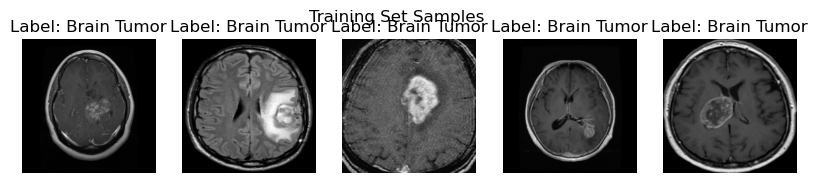

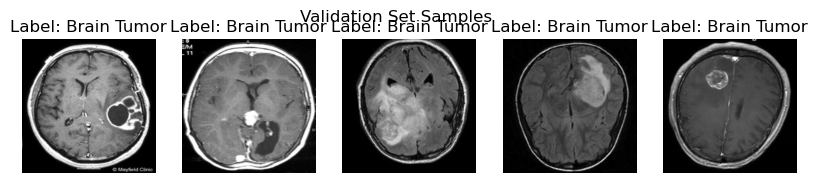

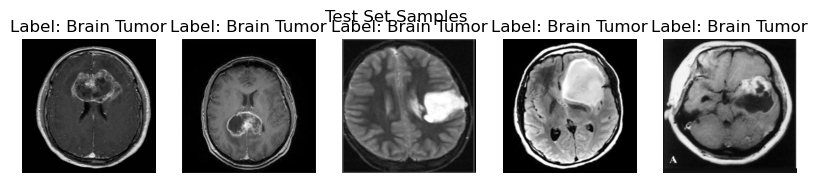

In [4]:
import matplotlib.pyplot as plt

def show_images(images, labels, title):
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Assuming preprocess_loaded_images function correctly processes and maintains the order of images
# Displaying the first 5 images and their labels from the training dataset
show_images(train_images_processed, train_labels, "Training Set Samples")

# Displaying the first 5 images and their labels from the validation dataset
show_images(valid_images_processed, valid_labels, "Validation Set Samples")

# Displaying the first 5 images and their labels from the test dataset
show_images(test_images_processed, test_labels, "Test Set Samples")


Shape of class_images: (256, 256)
Shape of average_image: (256, 256)


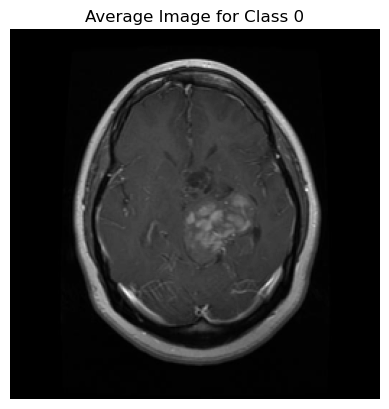

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_image(images, labels, class_label):
    # Filter images by class label
    class_images = images[labels == class_label]
    # Check the structure of class_images
    print(f"Shape of class_images: {class_images.shape}")
    
    if class_images.ndim == 2:  # This implies there is only one image in the class
        average_image = class_images  # Since there's only one image, it is the average
    else:
        # Compute the average image if there are multiple images
        average_image = np.mean(class_images, axis=0)
    
    print(f"Shape of average_image: {average_image.shape}")

    if average_image.ndim == 2:  # Typical for grayscale images
        plt.imshow(average_image, cmap='gray')
    elif average_image.ndim == 3 and average_image.shape[2] in [3, 4]:  # Typical for RGB or RGBA images
        plt.imshow(average_image.astype(np.uint8))
    else:
        print(f"Unexpected dimensions in average image: {average_image.shape}")
        return

    plt.title(f"Average Image for Class {class_label}")
    plt.axis('off')
    plt.show()

# Example usage, ensure that your train_images_processed and train_labels are correctly defined
compute_average_image(train_images_processed, train_labels, class_label=0)


# VISULIZING THE PREPROCESSING AND FEATURE ENGINERING 

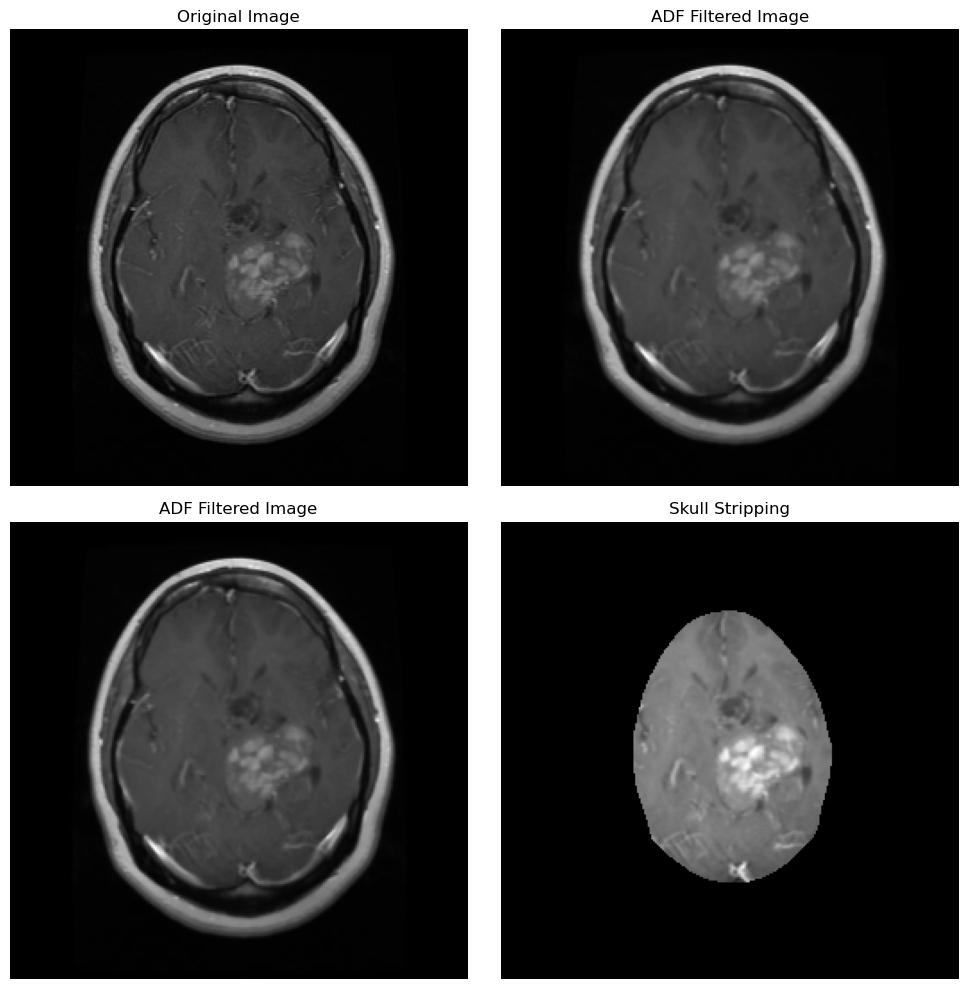

In [20]:
import numpy as np
from skimage.util import img_as_ubyte, img_as_float
from skimage import morphology, filters
from scipy.ndimage import convolve, gaussian_gradient_magnitude
import matplotlib.pyplot as plt


# ADF Function
def anisotropic_diffusion_filter(image, alpha=0.1, beta=0.1, iterations=3):
    image = img_as_float(image.copy())
    for _ in range(iterations):
        gradient_magnitude = gaussian_gradient_magnitude(image, sigma=1)
        c = 1.0 / (1.0 + (gradient_magnitude / beta) ** 2)
        diff_north = convolve(image, np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]]))
        diff_south = convolve(image, np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]]))
        diff_east = convolve(image, np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]]))
        diff_west = convolve(image, np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]]))
        image += alpha * (c * diff_north + c * diff_south + c * diff_east + c * diff_west)
    return img_as_ubyte(image)

# Skull Stripping Function
def skull_stripping(image, se_closing=None, se_erosion=None, skull_remove_area=2000):
    if se_closing is None:
        se_closing = morphology.disk(15)
    if se_erosion is None:
        se_erosion = morphology.disk(30)
    
    threshold_value = filters.threshold_otsu(image)
    binary_image = image > threshold_value
    filled_image = morphology.closing(binary_image, se_closing)
    filled_image = morphology.remove_small_holes(filled_image, area_threshold=skull_remove_area)
    eroded_image = morphology.erosion(filled_image, se_erosion)
    skull_stripped_image = np.where(eroded_image, image, 0)

    return img_as_ubyte(skull_stripped_image)


# Apply ADF and Skull Stripping
try:
    original_image = train_images_processed[0]  # Assuming this is the original image
    adf_filtered_image = anisotropic_diffusion_filter(original_image)
    skull_stripped_original = skull_stripping(original_image)
    skull_stripped_adf = skull_stripping(adf_filtered_image)

    # Plot the images in a 2x2 grid
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(original_image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(adf_filtered_image, cmap="gray")
    plt.title("ADF Filtered Image")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(adf_filtered_image, cmap="gray")
    plt.title("ADF Filtered Image")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(skull_stripped_adf, cmap="gray")
    plt.title("Skull Stripping")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {e}")



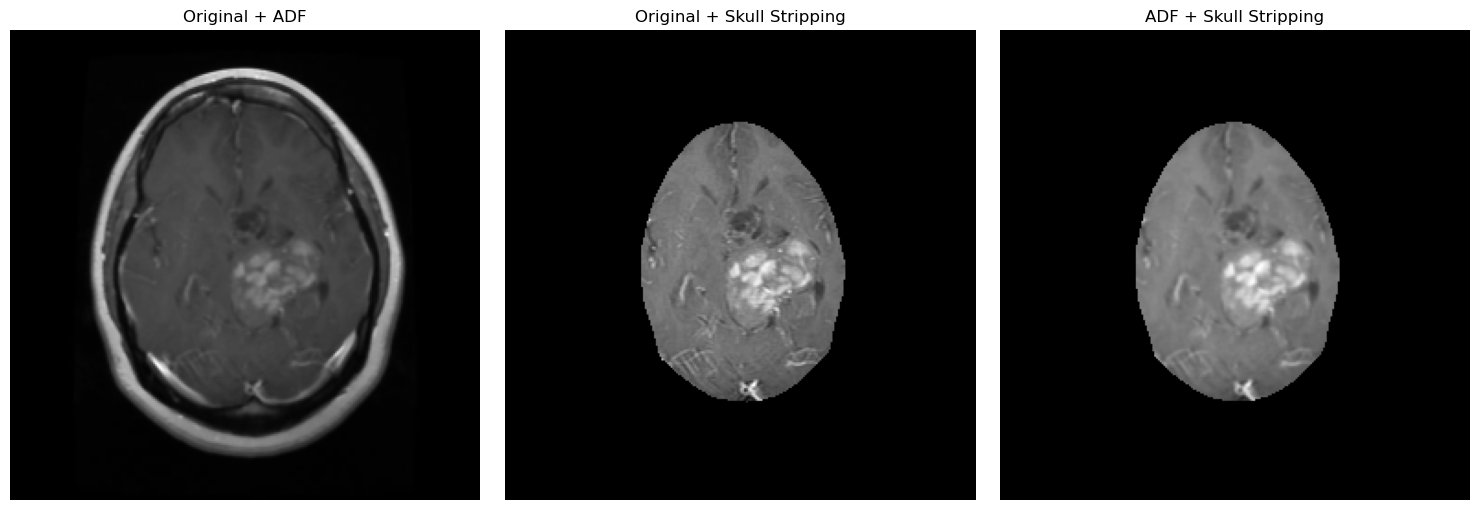

In [22]:
import numpy as np
from skimage.util import img_as_ubyte, img_as_float
from skimage import morphology, filters
from scipy.ndimage import convolve, gaussian_gradient_magnitude
import matplotlib.pyplot as plt


# ADF Function
def anisotropic_diffusion_filter(image, alpha=0.1, beta=0.1, iterations=3):
    image = img_as_float(image.copy())
    for _ in range(iterations):
        gradient_magnitude = gaussian_gradient_magnitude(image, sigma=1)
        c = 1.0 / (1.0 + (gradient_magnitude / beta) ** 2)
        diff_north = convolve(image, np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]]))
        diff_south = convolve(image, np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]]))
        diff_east = convolve(image, np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]]))
        diff_west = convolve(image, np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]]))
        image += alpha * (c * diff_north + c * diff_south + c * diff_east + c * diff_west)
    return img_as_ubyte(image)

# Skull Stripping Function
def skull_stripping(image, se_closing=None, se_erosion=None, skull_remove_area=1500):
    if se_closing is None:
        se_closing = morphology.disk(15)
    if se_erosion is None:
        se_erosion = morphology.disk(30)
    
    threshold_value = filters.threshold_otsu(image)
    binary_image = image > threshold_value
    filled_image = morphology.closing(binary_image, se_closing)
    filled_image = morphology.remove_small_holes(filled_image, area_threshold=skull_remove_area)
    eroded_image = morphology.erosion(filled_image, se_erosion)
    skull_stripped_image = np.where(eroded_image, image, 0)

    return img_as_ubyte(skull_stripped_image)


# Apply ADF and Skull Stripping
try:
    original_image = train_images_processed[0]  # Assuming this is the original image
    adf_filtered_image = anisotropic_diffusion_filter(original_image)
    skull_stripped_original = skull_stripping(original_image)
    skull_stripped_adf = skull_stripping(adf_filtered_image)

    # Plot the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(adf_filtered_image, cmap="gray")
    plt.title("Original + ADF")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(skull_stripped_original, cmap="gray")
    plt.title("Original + Skull Stripping")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(skull_stripped_adf, cmap="gray")
    plt.title("ADF + Skull Stripping")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error: {e}")


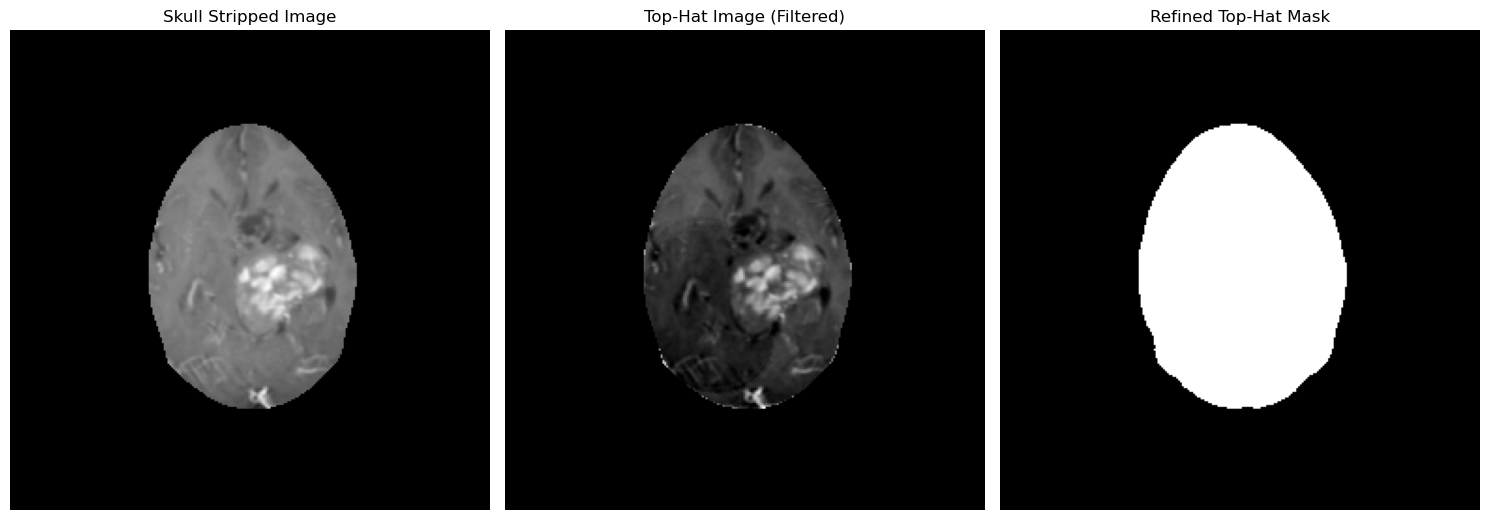

In [24]:
from skimage import morphology, exposure, filters
from skimage.morphology import remove_small_holes, closing
import matplotlib.pyplot as plt
import numpy as np

def top_hat_filtering(image, disk_size=20):
    # Create a disk-shaped structuring element
    footprint = morphology.disk(disk_size)

    # Apply white top-hat filtering
    tophat_image = morphology.white_tophat(image, footprint)
    return tophat_image

# Normalize Skull-Stripped Image (convert to float if needed)
skull_stripped_image = img_as_float(skull_stripped_adf)

# Apply Top-Hat Filtering with a smaller disk
tophat_image = top_hat_filtering(skull_stripped_image, disk_size=30)

# Use Otsu Thresholding for better mask extraction
tophat_thresh = filters.threshold_otsu(tophat_image)
tophat_binary = tophat_image > tophat_thresh

# Refine Top-Hat Result
filled_tophat = remove_small_holes(tophat_binary, area_threshold=1500)
refined_tophat = closing(filled_tophat, morphology.disk(15))


# Visualization
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(skull_stripped_image, cmap="gray")
plt.title("Skull Stripped Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(tophat_image, cmap="gray")
plt.title("Top-Hat Image (Filtered)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(refined_tophat, cmap="gray")
plt.title("Refined Top-Hat Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


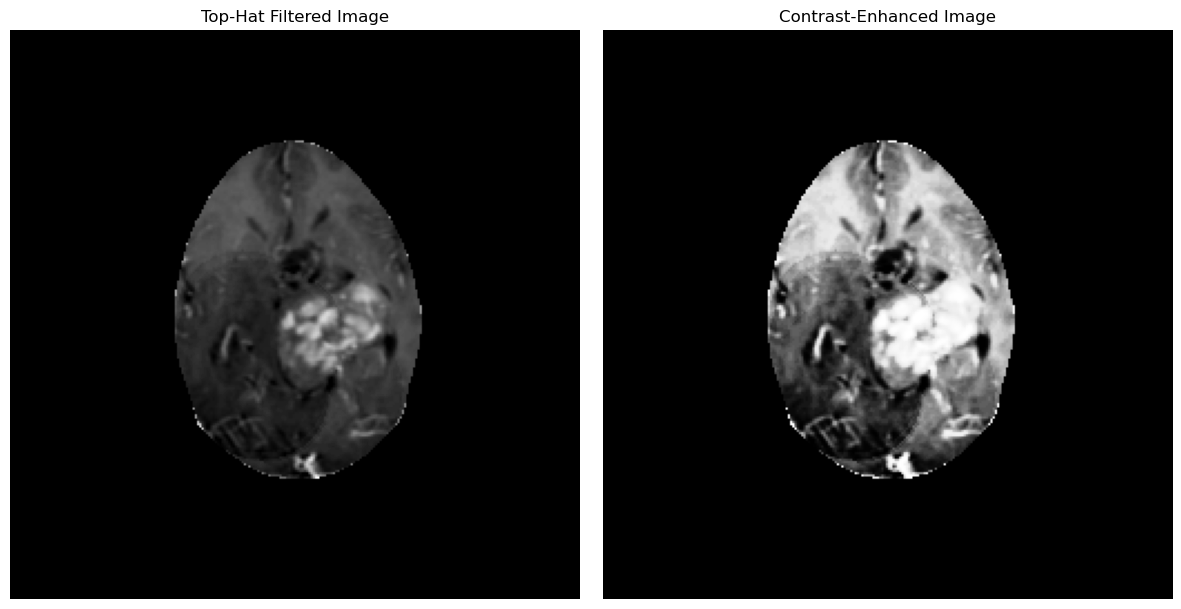

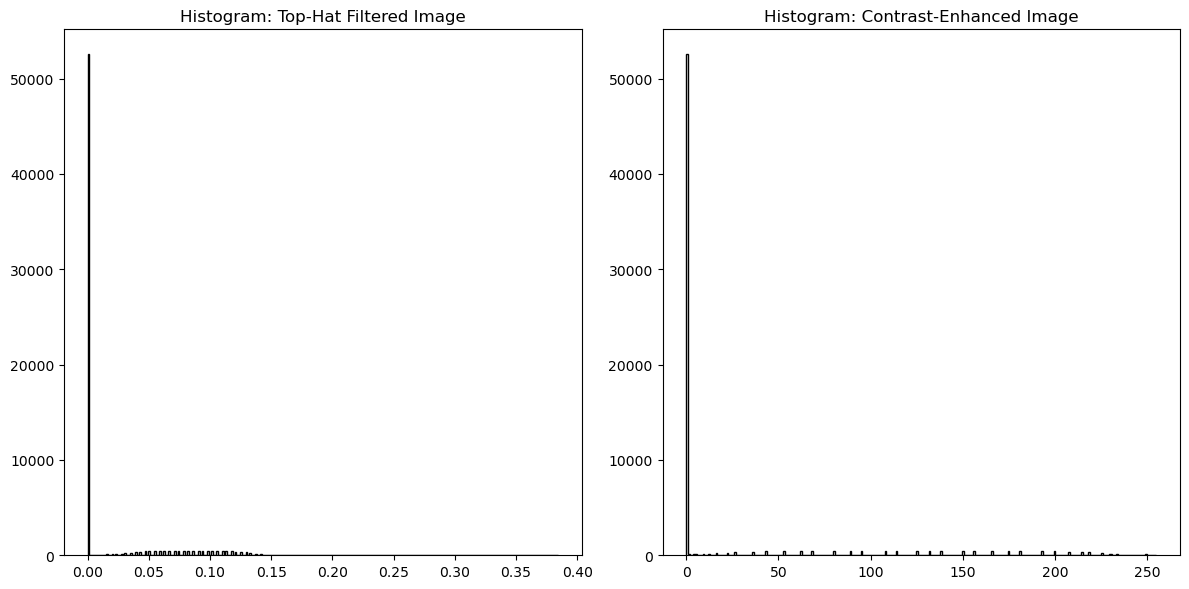

In [25]:
from skimage import exposure
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt

def normalize_image(image):
    """
    Normalize the image to range [0, 1].
    Args:
    - image (ndarray): Input image.

    Returns:
    - normalized_image (ndarray): Image normalized to [0, 1].
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def contrast_enhancement(image):
    """
    Enhance contrast using histogram equalization.

    Args:
    - image (ndarray): Input image.

    Returns:
    - contrasted_image (ndarray): Contrast-enhanced image in uint8 format.
    """
    contrasted_image = exposure.equalize_hist(image)  # Apply histogram equalization
    contrasted_image = normalize_image(contrasted_image)  # Normalize to [0, 1]
    return img_as_ubyte(contrasted_image)  # Convert to uint8

# Apply Contrast Enhancement to the Top-Hat Filtered Image
contrasted_image = contrast_enhancement(tophat_image)

# Display the Original (Top-Hat) and Contrast-Enhanced Images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(tophat_image, cmap="gray")
plt.title("Top-Hat Filtered Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(contrasted_image, cmap="gray")
plt.title("Contrast-Enhanced Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Optional: Display Histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(tophat_image.ravel(), bins=256, histtype="step", color="black")
plt.title("Histogram: Top-Hat Filtered Image")

plt.subplot(1, 2, 2)
plt.hist(contrasted_image.ravel(), bins=256, histtype="step", color="black")
plt.title("Histogram: Contrast-Enhanced Image")

plt.tight_layout()
plt.show()


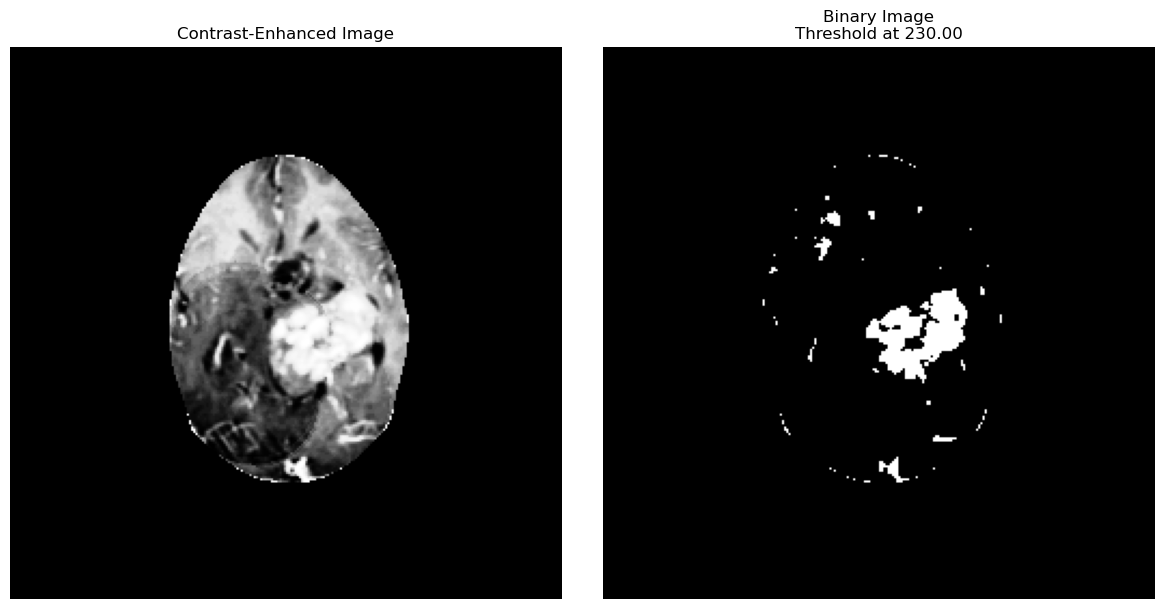

In [26]:
from skimage import filters
import matplotlib.pyplot as plt

def get_binary(image, thresh=None):
    """
    Generate a binary image using a specified threshold or Otsu's method.

    Args:
    - image (ndarray): Input grayscale image.
    - thresh (float, optional): Threshold value. If None, uses Otsu's thresholding.

    Returns:
    - binary_image (ndarray): Binary segmented image.
    - thresh (float): Applied threshold value.
    """
    if thresh is None:
        thresh = filters.threshold_otsu(image)
    binary_image = image > thresh
    return binary_image, thresh

# Apply Binary Segmentation
binary_image, thresh = get_binary(contrasted_image, 230)

# Display Binary Segmentation Results using matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(contrasted_image, cmap="gray")
plt.title("Contrast-Enhanced Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap="gray")
plt.title(f"Binary Image\nThreshold at {thresh:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()


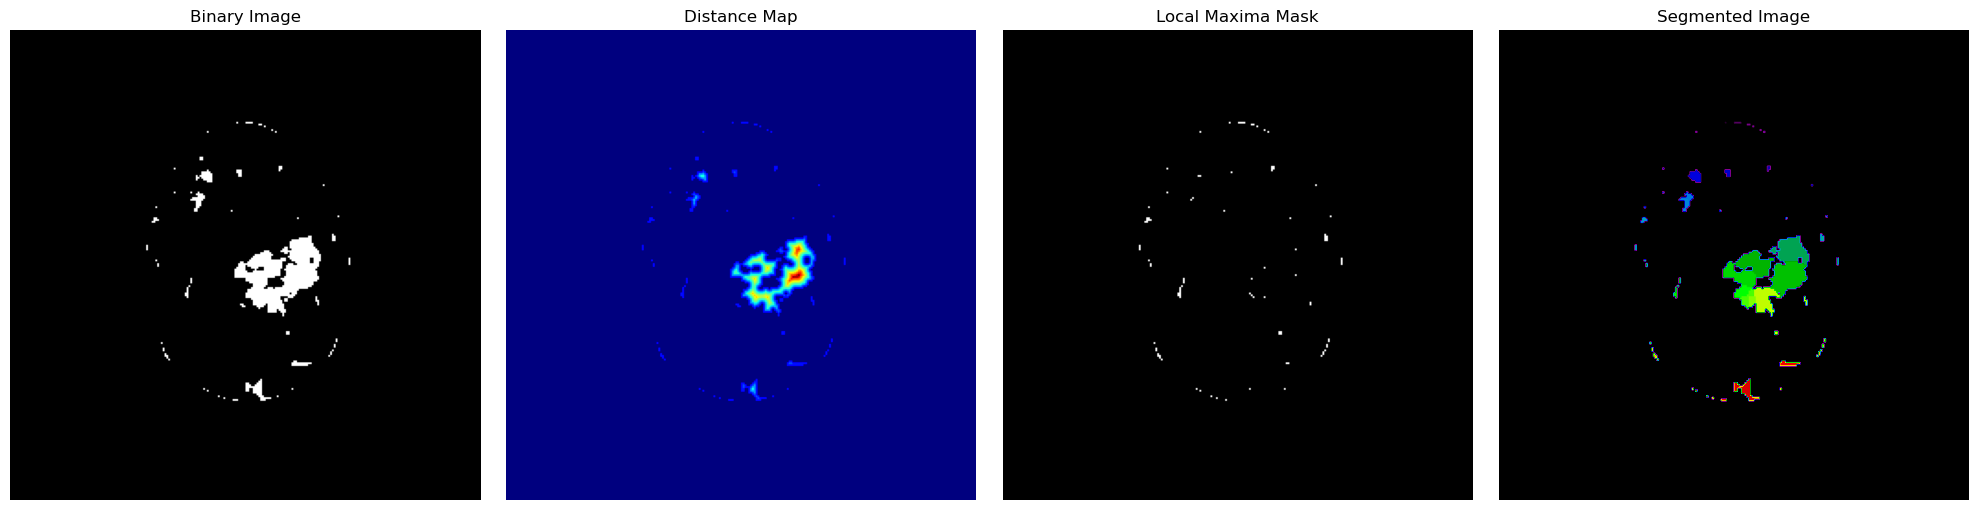

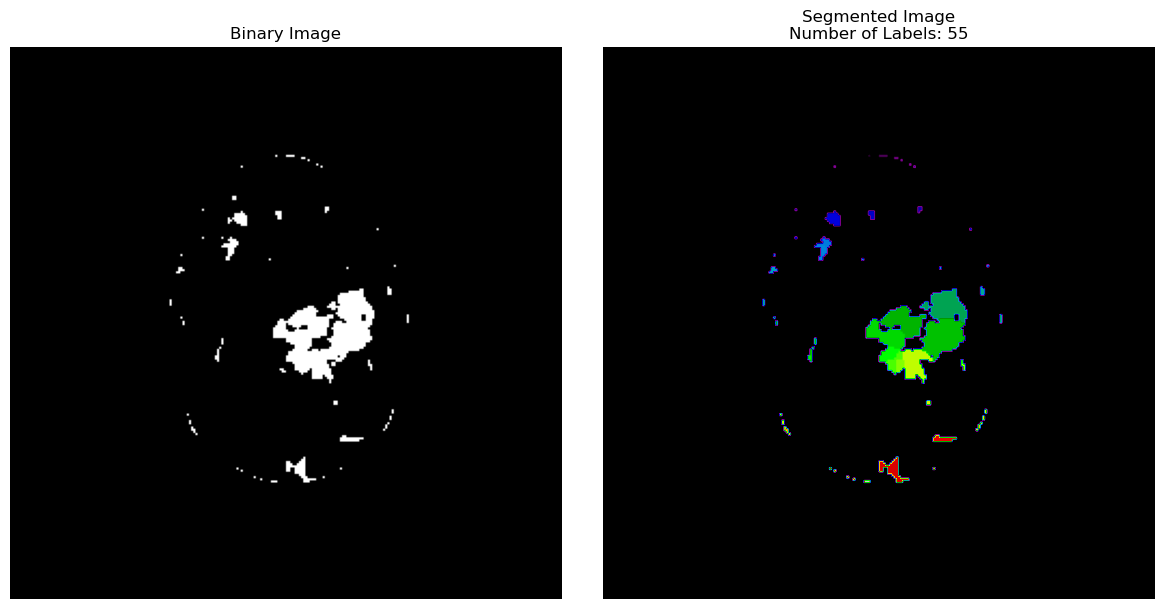

In [27]:
from skimage import segmentation, feature, morphology
from scipy.ndimage import distance_transform_edt, label as nd_label
import numpy as np
import matplotlib.pyplot as plt

def watershed_segmentation(image, se_peak_local=np.ones((3, 3)), show_pipeline=False):
    """
    Perform Watershed Segmentation on a binary image.

    Args:
    - image (ndarray): Input binary image.
    - se_peak_local (ndarray): Structuring element for detecting local maxima. Default is a 3x3 array.
    - show_pipeline (bool): Whether to show intermediate steps in the pipeline. Default is False.

    Returns:
    - segmented_image (ndarray): Segmented image with labeled regions.
    - nbr_labels (int): Number of unique labels in the segmented image.
    """
    # Compute the distance map
    distance = distance_transform_edt(image)

    # Determine the local maxima of the distance map
    local_maxi = feature.peak_local_max(
        distance,
        labels=image,
        footprint=se_peak_local,
        exclude_border=False  # Ensures maxima near edges are considered
    )

    # Convert the local maxima into a binary mask
    local_maxi_mask = np.zeros_like(image, dtype=bool)
    local_maxi_mask[tuple(local_maxi.T)] = True

    # Create markers for the watershed algorithm
    markers = nd_label(local_maxi_mask)[0]

    # Apply the watershed algorithm
    segmented_image = segmentation.watershed(-distance, markers, mask=image)

    # Count the number of labels
    nbr_labels = np.max(segmented_image)

    # Optional: Display the intermediate results
    if show_pipeline:
        plt.figure(figsize=(20, 5))
        images = [image, distance, local_maxi_mask, segmented_image]
        titles = ["Binary Image", "Distance Map", "Local Maxima Mask", "Segmented Image"]
        cmaps = [None, "jet", "gray", "nipy_spectral"]
        for i, (img, title, cmap) in enumerate(zip(images, titles, cmaps)):
            plt.subplot(1, 4, i + 1)
            plt.imshow(img, cmap=cmap if cmap else "gray")
            plt.title(title)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    return segmented_image, nbr_labels


# Example Binary Image (Replace with Your Image)
# Replace binary_image with your actual binary data
segmented_image, nbr_labels = watershed_segmentation(
    binary_image,
    se_peak_local=morphology.disk(10),  # Structuring element for local maxima
    show_pipeline=True
)

# Display Final Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap="gray")
plt.title("Binary Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap="nipy_spectral")
plt.title(f"Segmented Image\nNumber of Labels: {nbr_labels}")
plt.axis("off")

plt.tight_layout()
plt.show()


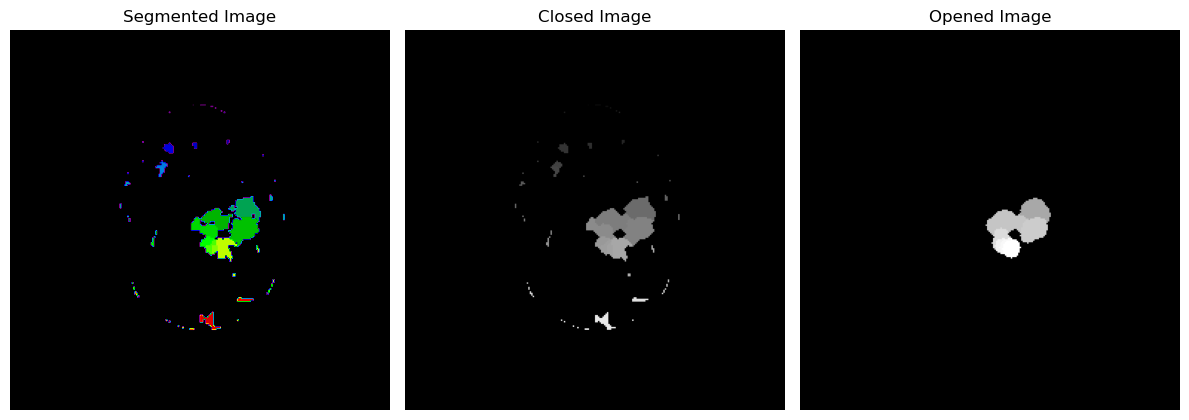

In [33]:
from skimage import morphology
import matplotlib.pyplot as plt

# Apply morphological operations
closed_image = morphology.closing(segmented_image, morphology.disk(2))  # Closing operation
opened_image = morphology.opening(closed_image, morphology.disk(5))  # Opening operation

# Display the original, closed, and opened images
plt.figure(figsize=(12, 6))

# Segmented Image
plt.subplot(1, 3, 1)
plt.imshow(segmented_image, cmap="nipy_spectral")
plt.title("Segmented Image")
plt.axis("off")

# Closed Image (apply correct image)
plt.subplot(1, 3, 2)
plt.imshow(closed_image, cmap="gray")  # Use "gray" for closed binary results
plt.title("Closed Image")
plt.axis("off")

# Opened Image
plt.subplot(1, 3, 3)
plt.imshow(opened_image, cmap="gray")  # Use "gray" for opened binary results
plt.title("Opened Image")
plt.axis("off")

plt.tight_layout()
plt.show()


# COMPINE THE PIPLINE AND GETTING READY FOR FLATTING

In [33]:
from skimage.util import img_as_ubyte, img_as_float
from skimage import morphology, filters, segmentation, exposure, feature
from scipy.ndimage import convolve, gaussian_gradient_magnitude, distance_transform_edt
from scipy.ndimage import label as nd_label
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import cv2

# Step 1: Anisotropic Diffusion Filter (ADF)
def anisotropic_diffusion_filter(image, alpha=0.1, beta=0.1, iterations=3):
    image = img_as_float(image.copy())
    for _ in range(iterations):
        gradient_magnitude = gaussian_gradient_magnitude(image, sigma=1)
        c = 1.0 / (1.0 + (gradient_magnitude / beta) ** 2)
        diff_north = convolve(image, np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]]))
        diff_south = convolve(image, np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]]))
        diff_east = convolve(image, np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]]))
        diff_west = convolve(image, np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]]))
        image += alpha * (c * diff_north + c * diff_south + c * diff_east + c * diff_west)
    return img_as_ubyte(image)

# Step 2: Skull Stripping
def skull_stripping(image, se_closing=None, se_erosion=None, skull_remove_area=2000):
    if se_closing is None:
        se_closing = morphology.disk(15)
    if se_erosion is None:
        se_erosion = morphology.disk(30)
    threshold_value = filters.threshold_otsu(image)
    binary_image = image > threshold_value
    filled_image = morphology.closing(binary_image, se_closing)
    filled_image = morphology.remove_small_holes(filled_image, area_threshold=skull_remove_area)
    eroded_image = morphology.erosion(filled_image, se_erosion)
    return np.where(eroded_image, image, 0)

# Step 3: Top-Hat Filtering
def top_hat_filtering(image, disk_size=30):
    footprint = morphology.disk(disk_size)
    return morphology.white_tophat(image, footprint)

# Step 4: Contrast Enhancement
def contrast_enhancement(image):
    contrasted_image = exposure.equalize_hist(image)
    contrasted_image = (contrasted_image - np.min(contrasted_image)) / (np.max(contrasted_image) - np.min(contrasted_image))
    return img_as_ubyte(contrasted_image)

# Step 5: Binary Segmentation
def get_binary(image, thresh=None):
    if thresh is None:
        thresh = filters.threshold_otsu(image)
    binary_image = image > thresh
    return binary_image, thresh

# Step 6: Watershed Segmentation
def watershed_segmentation(image, se_peak_local=np.ones((3, 3))):
    distance = distance_transform_edt(image)
    local_maxi = feature.peak_local_max(distance, labels=image, footprint=se_peak_local, exclude_border=False)
    local_maxi_mask = np.zeros_like(image, dtype=bool)
    local_maxi_mask[tuple(local_maxi.T)] = True
    markers = nd_label(local_maxi_mask)[0]  # Use `nd_label` here
    segmented_image = segmentation.watershed(-distance, markers, mask=image)
    nbr_labels = np.max(segmented_image)
    return segmented_image, nbr_labels


# Step 7: Morphological Operations
def apply_morphological_operations(segmented_image):
    if not isinstance(segmented_image, np.ndarray) or segmented_image.ndim != 2:
        return None, None  # Prevent errors if input is invalid
    
    closed_image = morphology.closing(segmented_image, morphology.disk(6))
    opened_image = morphology.opening(closed_image, morphology.disk(5))
    
    return closed_image, opened_image


Opened Image Type: <class 'numpy.ndarray'>, Shape: (256, 256)


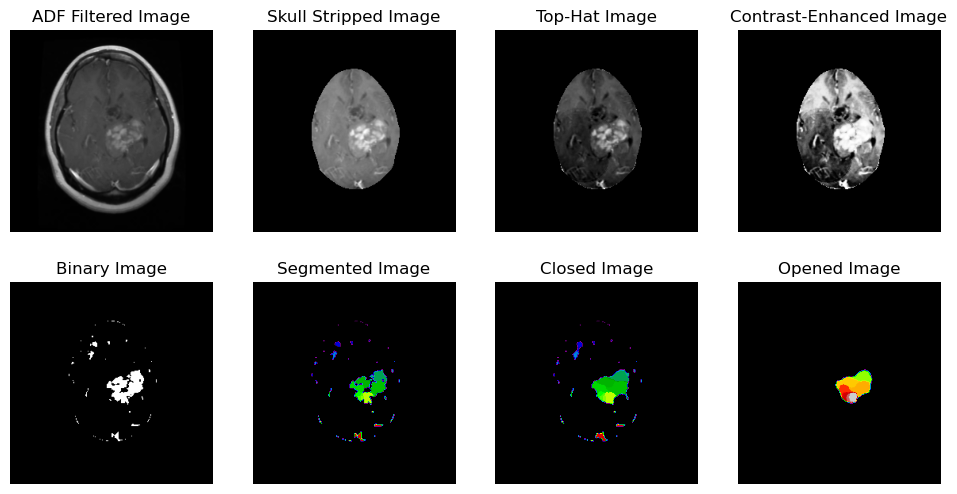

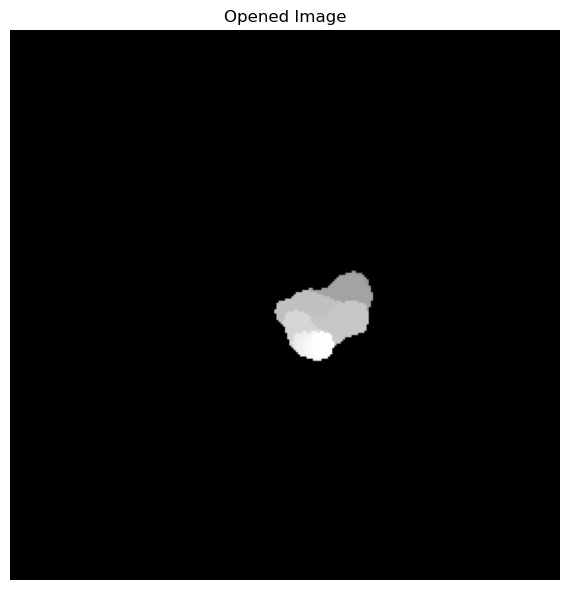

In [43]:
# Execute the full pipeline
def full_pipeline(image):
    adf_filtered_image = anisotropic_diffusion_filter(image)
    skull_stripped_image = skull_stripping(adf_filtered_image)
    tophat_image = top_hat_filtering(skull_stripped_image)
    contrasted_image = contrast_enhancement(tophat_image)
    binary_image, thresh = get_binary(contrasted_image, thresh=230)
    segmented_image, nbr_labels = watershed_segmentation(binary_image, morphology.disk(10))
    closed_image_post, opened_image = apply_morphological_operations(segmented_image)

    # 🔥 Free GPU memory only once at the end
    cp.get_default_memory_pool().free_all_blocks()
    
    return (
       adf_filtered_image,
        skull_stripped_image,
        tophat_image,
        contrasted_image,
        binary_image,
        segmented_image,
        closed_image_post,
        opened_image,
        thresh,
        nbr_labels,
    )

# Example image input
image = train_images_processed[0]

# Run the pipeline
results = full_pipeline(image)

# Extract outputs
(adf_filtered_image,skull_stripped_image, tophat_image, contrasted_image, binary_image, 
 segmented_image, closed_image_post, opened_image, thresh, nbr_labels) = results

# Debug: Print the shape and type of Opened Image
print(f"Opened Image Type: {type(opened_image)}, Shape: {opened_image.shape if isinstance(opened_image, np.ndarray) else 'Scalar/None'}")
 
# Visualization
titles = [
    "ADF Filtered Image",
    "Skull Stripped Image",
    "Top-Hat Image",
    "Contrast-Enhanced Image",
    "Binary Image",
    "Segmented Image",
    "Closed Image",
    "Opened Image"
]


# Function to create blank image with text
def create_blank_image_with_text(text, width=256, height=256):
    blank_img = np.zeros((height, width), dtype=np.uint8)
    cv2.putText(blank_img, str(text), (10, height // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 255, 2, cv2.LINE_AA)
    return blank_img

# Visualize images
plt.figure(figsize=(12, 6))

for i, (title, img) in enumerate(zip(titles, results[:-2])):  # Exclude scalars (thresh, nbr_labels)
    plt.subplot(2, 4, i + 1)
    
    if isinstance(img, np.ndarray) and img.ndim == 2:
        plt.imshow(img, cmap="gray" if i < 5 else "nipy_spectral")
    else:
        blank_image = create_blank_image_with_text("Invalid Image")
        plt.imshow(blank_image, cmap="gray")
    
    plt.title(title)
    plt.axis("off")

# Display Opened Image separately
plt.figure(figsize=(6, 6))

if isinstance(opened_image, np.ndarray) and opened_image.ndim == 2:
    plt.imshow(opened_image, cmap="gray")
else:
    blank_image = create_blank_image_with_text("Invalid Image")
    plt.imshow(blank_image, cmap="gray")

plt.title("Opened Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

class ImagePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No hyperparameters for now

    def fit(self, X, y=None):
        return self  # No training needed

    def transform(self, X):
        processed_images = []
        for image in X:
            try:
                # Apply the full pipeline to each image
                adf_filtered_image = anisotropic_diffusion_filter(image)
                skull_stripped_image = skull_stripping(adf_filtered_image)
                tophat_image = top_hat_filtering(skull_stripped_image)
                contrasted_image = contrast_enhancement(tophat_image)
                binary_image, _ = get_binary(contrasted_image, thresh=230)
                segmented_image, _ = watershed_segmentation(binary_image, morphology.disk(10))
                _, opened_image = apply_morphological_operations(segmented_image)

                # Resize to 256x256
                resized_opened_image = transform.resize(opened_image, (256, 256), anti_aliasing=True)
                if resized_opened_image.max() > 0:
                    resized_opened_image = (resized_opened_image / resized_opened_image.max()) * 255
                resized_opened_image = resized_opened_image.astype(np.uint8)

                # Flatten the image
                flattened_image = resized_opened_image.flatten().reshape(1, -1)
                
                processed_images.append(flattened_image)
            except Exception as e:
                print(f"Error processing image: {e}")
                processed_images.append(None)

        return np.vstack(processed_images)  # Stack all images together

# Instantiate the preprocessor
preprocessor = ImagePreprocessor()

joblib.dump(preprocessor, r"C:\Marwan APU\Sem-2\PR\brine\new_pkl\preprocessing_pipeline.pkl")
print("Pipeline saved successfully!")



Pipeline saved successfully!


# FLATTING, SCALING, ENCODING, BALANCING AND DATA SPLITING 

In [4]:
from joblib import Parallel, delayed
from skimage.transform import resize
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np

# Resize Images
def resize_images(images, target_size=(128, 128)):
    return [resize(image, target_size, anti_aliasing=True) for image in images]

# Process a single image (optimized)
def process_single_image(image, label):
    # Get the dictionary returned by full_pipeline and extract the 'Segmented' result
    results = full_pipeline(image)
    segmented_image = results["Binary"]
    return segmented_image, label

# Full feature engineering pipeline with optimizations
def feature_engineering(images, labels, resize_target=(128, 128), balance=False):
    # Resize images
    resized_images = resize_images(images, resize_target)

    # Parallel processing through the pipeline
    processed_results = Parallel(n_jobs=-1)(
        delayed(process_single_image)(image, label) for image, label in zip(resized_images, labels)
    )
    processed_images, processed_labels = zip(*processed_results)

    # Flatten images
    flattened_images = np.array([img.ravel() for img in processed_images])

    # Scale features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(flattened_images)

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(processed_labels)

    # Balance the dataset (if specified)
    if balance:
        smote = SMOTE(random_state=42)
        balanced_features, balanced_labels = smote.fit_resample(scaled_features, encoded_labels)
        return balanced_features, balanced_labels, label_encoder

    return scaled_features, encoded_labels, label_encoder

# Apply the pipeline to training, testing, and validation datasets
train_features, train_labels, train_label_encoder = feature_engineering(train_images_processed, train_labels, balance=True)
test_features, test_labels, _ = feature_engineering(test_images_processed, test_labels, balance=False)
valid_features, valid_labels, _ = feature_engineering(valid_images_processed, valid_labels, balance=False)

# Output shapes for verification
print(f"Training Features Shape: {train_features.shape}")
print(f"Testing Features Shape: {test_features.shape}")
print(f"Validation Features Shape: {valid_features.shape}")


Training Features Shape: (3436, 16384)
Testing Features Shape: (395, 16384)
Validation Features Shape: (388, 16384)


In [9]:
import joblib

# Create a dictionary with the functions you want to save
pipeline_and_feature_engineering = {
    "full_pipeline": full_pipeline,
    "feature_engineering": feature_engineering
}

# Save the dictionary to a .pkl file
joblib.dump(pipeline_and_feature_engineering, r'C:\Marwan APU\Sem-2\PR\brine\new_pkl\image_processing_pipeline.pkl')

print("Pipeline and feature engineering saved as 'image_processing_pipeline.pkl'")


Pipeline and feature engineering saved as 'image_processing_pipeline.pkl'


# Random forest 

In [10]:
# Step 1: Import required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# For demonstration purposes, assume that you already have these datasets 
# from your feature engineering pipeline:
# train_features, train_labels, train_label_encoder = feature_engineering(train_images_processed, train_labels, balance=True)
# test_features, test_labels, _ = feature_engineering(test_images_processed, test_labels, balance=False)
# valid_features, valid_labels, _ = feature_engineering(valid_images_processed, valid_labels, balance=False)

# Step 2: Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)


# Step 3: Train the model on the training data
rf_model.fit(train_features, train_labels)

# Step 4: Evaluate the model on the training set
train_predictions = rf_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Step 5: Evaluate the model on the test set
test_predictions = rf_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Step 6: Evaluate the model on the validation set
valid_predictions = rf_model.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


Training Accuracy: 0.9269499417927823

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      1718
           1       0.96      0.89      0.92      1718

    accuracy                           0.93      3436
   macro avg       0.93      0.93      0.93      3436
weighted avg       0.93      0.93      0.93      3436

Confusion Matrix on Training Data:
 [[1662   56]
 [ 195 1523]]

Test Accuracy: 0.8734177215189873

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       197
           1       0.92      0.82      0.87       198

    accuracy                           0.87       395
   macro avg       0.88      0.87      0.87       395
weighted avg       0.88      0.87      0.87       395

Confusion Matrix on Test Data:
 [[182  15]
 [ 35 163]]

Validation Accuracy: 0.8943298969072165

Classification Report on Validati

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Adjusted hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

# Step 1: Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Step 2: Implement RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   n_iter=5, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_search.fit(train_features, train_labels)

# Best hyperparameters from RandomizedSearchCV
print("Best Hyperparameters:", random_search.best_params_)

# Step 3: Evaluate the best model using cross-validation
best_rf_model = random_search.best_estimator_

# Cross-validation score (accuracy)
cv_scores = cross_val_score(best_rf_model, train_features, train_labels, cv=3, n_jobs=-1)
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

# Step 4: Evaluate on training data using the best model
train_predictions = best_rf_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("\nTraining Accuracy:", train_accuracy)

# Step 5: Evaluate on test data using the best model
test_predictions = best_rf_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}
Cross-Validation Accuracy Scores: [0.93717277 0.91790393 0.79563319]
Mean Cross-Validation Accuracy: 0.88356996425768

Training Accuracy: 0.9650756693830035

Test Accuracy: 0.9113924050632911


In [9]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Save the best model to a .pkl file
joblib.dump(best_rf_model, r'C:\Marwan APU\Sem-2\PR\brine\new_pkl\best_random_forest_model.pkl')
print("Model saved as 'best_random_forest_model.pkl'")

Model saved as 'best_random_forest_model.pkl'


# Logistic Regression

In [11]:
# Step 1: Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# For demonstration purposes, assume that you already have these datasets 
# from your feature engineering pipeline:
# train_features, train_labels, train_label_encoder = feature_engineering(train_images_processed, train_labels, balance=True)
# test_features, test_labels, _ = feature_engineering(test_images_processed, test_labels, balance=False)
# valid_features, valid_labels, _ = feature_engineering(valid_images_processed, valid_labels, balance=False)

# Step 2: Initialize the Logistic Regression model
lr_model = LogisticRegression(solver='liblinear', random_state=42)

# Step 3: Train the model on the training data
lr_model.fit(train_features, train_labels)

# Step 4: Evaluate the model on the training set
train_predictions = lr_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Step 5: Evaluate the model on the test set
test_predictions = lr_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Step 6: Evaluate the model on the validation set
valid_predictions = lr_model.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


Training Accuracy: 0.9956344586728755

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1718
           1       0.99      1.00      1.00      1718

    accuracy                           1.00      3436
   macro avg       1.00      1.00      1.00      3436
weighted avg       1.00      1.00      1.00      3436

Confusion Matrix on Training Data:
 [[1703   15]
 [   0 1718]]

Test Accuracy: 0.9367088607594937

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       197
           1       0.94      0.93      0.94       198

    accuracy                           0.94       395
   macro avg       0.94      0.94      0.94       395
weighted avg       0.94      0.94      0.94       395

Confusion Matrix on Test Data:
 [[186  11]
 [ 14 184]]

Validation Accuracy: 0.9407216494845361

Classification Report on Validati

In [13]:
import pickle
# Step 3: Save the trained model to a .pkl file
with open(r"C:\Marwan APU\Sem-2\PR\brine\new_pkl\logistic_regression_model.pkl", "wb") as file:
    pickle.dump(lr_model, file)

print("Logistic Regression model saved as 'logistic_regression_model.pkl'")

Logistic Regression model saved as 'logistic_regression_model.pkl'


In [12]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model with built-in cross-validation.
# Here, Cs defines the inverse regularization strengths to try.
lr_cv_model = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10, 100],    # Try a range of regularization strengths.
    cv=10,                          # 5-fold cross-validation.
    solver='liblinear',            # 'liblinear' is good for small to medium datasets.
    random_state=42,
    penalty='l2',                  # You can change to 'l1' if desired.
    scoring='accuracy'
)

# Train the model on the training data
lr_cv_model.fit(train_features, train_labels)

# Evaluate the model on the training set
train_predictions = lr_cv_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Evaluate the model on the test set
test_predictions = lr_cv_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Evaluate the model on the validation set
valid_predictions = lr_cv_model.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


Training Accuracy: 0.9953434225844005

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1718
           1       0.99      1.00      1.00      1718

    accuracy                           1.00      3436
   macro avg       1.00      1.00      1.00      3436
weighted avg       1.00      1.00      1.00      3436

Confusion Matrix on Training Data:
 [[1702   16]
 [   0 1718]]

Test Accuracy: 0.9367088607594937

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       197
           1       0.94      0.93      0.94       198

    accuracy                           0.94       395
   macro avg       0.94      0.94      0.94       395
weighted avg       0.94      0.94      0.94       395

Confusion Matrix on Test Data:
 [[185  12]
 [ 13 185]]

Validation Accuracy: 0.9407216494845361

Classification Report on Validati

# KNN

In [11]:
# Step 1: Import required libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# For demonstration purposes, assume that you already have these datasets 
# from your feature engineering pipeline:
# train_features, train_labels, train_label_encoder = feature_engineering(train_images_processed, train_labels, balance=True)
# test_features, test_labels, _ = feature_engineering(test_images_processed, test_labels, balance=False)
# valid_features, valid_labels, _ = feature_engineering(valid_images_processed, valid_labels, balance=False)

# Step 2: Initialize the k-Nearest Neighbors model
# You can adjust n_neighbors based on your dataset. A common starting value is 5.
knn_model = KNeighborsClassifier(n_neighbors=5)

# Step 3: Train the model on the training data
knn_model.fit(train_features, train_labels)

# Step 4: Evaluate the model on the training set
train_predictions = knn_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Step 5: Evaluate the model on the test set
test_predictions = knn_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Step 6: Evaluate the model on the validation set
valid_predictions = knn_model.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


Training Accuracy: 0.9225844004656577

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      1718
           1       0.90      0.95      0.92      1718

    accuracy                           0.92      3436
   macro avg       0.92      0.92      0.92      3436
weighted avg       0.92      0.92      0.92      3436

Confusion Matrix on Training Data:
 [[1545  173]
 [  93 1625]]

Test Accuracy: 0.8911392405063291

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       197
           1       0.87      0.91      0.89       198

    accuracy                           0.89       395
   macro avg       0.89      0.89      0.89       395
weighted avg       0.89      0.89      0.89       395

Confusion Matrix on Test Data:
 [[171  26]
 [ 17 181]]

Validation Accuracy: 0.8891752577319587

Classification Report on Validati

In [12]:
# Step 1: Import required libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Assume these datasets are already generated by your feature engineering pipeline:
# train_features, train_labels, test_features, test_labels, valid_features, valid_labels

# Step 2: Set up a grid search to find the best k (number of neighbors)
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Try a range of neighbor values
    'weights': ['uniform', 'distance']  # Try both uniform and distance weighting
}

# Create a basic KNN classifier instance
knn = KNeighborsClassifier()

# Perform grid search with 5-fold cross-validation on the training set
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_features, train_labels)

print("Best Parameters from GridSearch:", grid_search.best_params_)

# Use the best estimator from grid search
best_knn = grid_search.best_estimator_

# Step 3: Evaluate the model on the training set
train_predictions = best_knn.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Step 4: Evaluate the model on the test set
test_predictions = best_knn.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Step 5: Evaluate the model on the validation set
valid_predictions = best_knn.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))

Best Parameters from GridSearch: {'n_neighbors': 3, 'weights': 'distance'}
Training Accuracy: 0.9874854481955763

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1718
           1       1.00      0.97      0.99      1718

    accuracy                           0.99      3436
   macro avg       0.99      0.99      0.99      3436
weighted avg       0.99      0.99      0.99      3436

Confusion Matrix on Training Data:
 [[1718    0]
 [  43 1675]]

Test Accuracy: 0.9215189873417722

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       197
           1       0.91      0.94      0.92       198

    accuracy                           0.92       395
   macro avg       0.92      0.92      0.92       395
weighted avg       0.92      0.92      0.92       395

Confusion Matrix on Test Data:
 [[178  19]
 [ 12 186]]


In [15]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Save the best model to a .pkl file
joblib.dump(best_knn, r'C:\Marwan APU\Sem-2\PR\brine\new_pkl\best_KNN_model.pkl')
print("Model saved as 'best_knn_model.pkl'")

Model saved as 'best_knn_model.pkl'


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Assume that train_features, train_labels, test_features, test_labels, valid_features, valid_labels
# are already available from your feature engineering pipeline.

# Define the parameter distributions to sample from
param_distributions = {
    'n_neighbors': np.arange(1, 20),          # Consider neighbors from 1 to 20
    'weights': ['uniform', 'distance']        # Try both weighting options
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_distributions,
    n_iter=20,              # Number of parameter settings that are sampled
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Run the random search on the training data
random_search.fit(train_features, train_labels)

# Output the best parameters found by random search
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Use the best estimator from the search
best_knn = random_search.best_estimator_

# Evaluate on the training set
train_predictions = best_knn.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Evaluate on the test set
test_predictions = best_knn.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Evaluate on the validation set
valid_predictions = best_knn.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


Best Parameters from RandomizedSearchCV: {'weights': 'uniform', 'n_neighbors': 1}
Training Accuracy: 0.9874854481955763

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1718
           1       1.00      0.97      0.99      1718

    accuracy                           0.99      3436
   macro avg       0.99      0.99      0.99      3436
weighted avg       0.99      0.99      0.99      3436

Confusion Matrix on Training Data:
 [[1718    0]
 [  43 1675]]

Test Accuracy: 0.9189873417721519

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       197
           1       0.90      0.95      0.92       198

    accuracy                           0.92       395
   macro avg       0.92      0.92      0.92       395
weighted avg       0.92      0.92      0.92       395

Confusion Matrix on Test Data:
 [[175  22]
 [ 10

# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume that train_features, train_labels, test_features, test_labels, valid_features, valid_labels
# are already available from your feature engineering pipeline.

# Initialize the Decision Tree with default parameters
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
dt_model.fit(train_features, train_labels)

# Evaluate on the training set
train_predictions = dt_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Evaluate on the test set
test_predictions = dt_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Evaluate on the validation set
valid_predictions = dt_model.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


Training Accuracy: 0.9915599534342259

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1718
           1       0.98      1.00      0.99      1718

    accuracy                           0.99      3436
   macro avg       0.99      0.99      0.99      3436
weighted avg       0.99      0.99      0.99      3436

Confusion Matrix on Training Data:
 [[1689   29]
 [   0 1718]]

Test Accuracy: 0.8936708860759494

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       197
           1       0.89      0.89      0.89       198

    accuracy                           0.89       395
   macro avg       0.89      0.89      0.89       395
weighted avg       0.89      0.89      0.89       395

Confusion Matrix on Test Data:
 [[176  21]
 [ 21 177]]

Validation Accuracy: 0.9226804123711341

Classification Report on Validati

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Convert features to float32 to reduce memory usage
train_features = np.asarray(train_features, dtype=np.float32)
test_features = np.asarray(test_features, dtype=np.float32)
valid_features = np.asarray(valid_features, dtype=np.float32)

# Define the parameter distributions for random search
param_distributions = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

# Initialize the basic Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Set up RandomizedSearchCV with a limited number of parallel jobs to conserve memory
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_distributions,
    n_iter=20,                # Number of parameter settings to sample
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=1                  # Use 1 (or a small number) instead of -1 to reduce memory load
)

# Run the random search on the training data
random_search.fit(train_features, train_labels)

# Output the best parameters found by random search
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Use the best estimator from random search
best_dt = random_search.best_estimator_

# Evaluate on the training set
train_predictions = best_dt.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Evaluate on the test set
test_predictions = best_dt.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Evaluate on the validation set
valid_predictions = best_dt.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


Best Parameters from RandomizedSearchCV: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini'}
Training Accuracy: 0.9575087310826542

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1718
           1       0.98      0.93      0.96      1718

    accuracy                           0.96      3436
   macro avg       0.96      0.96      0.96      3436
weighted avg       0.96      0.96      0.96      3436

Confusion Matrix on Training Data:
 [[1689   29]
 [ 117 1601]]

Test Accuracy: 0.8658227848101265

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       197
           1       0.89      0.83      0.86       198

    accuracy                           0.87       395
   macro avg       0.87      0.87      0.87       395
weighted avg       0.87      0.87      0.87       395

Co

In [19]:
import pickle
# Step 3: Save the trained model to a .pkl file
with open(r"C:\Marwan APU\Sem-2\PR\brine\new_pkl\Decision_tree_model.pkl", "wb") as file:
    pickle.dump(best_dt, file)

print("Decision Tree model saved as 'Decision_tree_model.pkl'")

Decision Tree model saved as 'Decision_tree_model.pkl'


In [18]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Convert features to float32
train_features = np.asarray(train_features, dtype=np.float32)
test_features = np.asarray(test_features, dtype=np.float32)
valid_features = np.asarray(valid_features, dtype=np.float32)

# Apply PCA to reduce dimensions (adjust n_components as needed)
pca = PCA(n_components=100, random_state=42)
train_features_reduced = pca.fit_transform(train_features)
test_features_reduced = pca.transform(test_features)
valid_features_reduced = pca.transform(valid_features)

# Define the parameter distributions for random search
param_distributions = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Set up RandomizedSearchCV (using n_jobs=1 for memory considerations)
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=1
)

# Run the random search on the PCA-reduced training data
random_search.fit(train_features_reduced, train_labels)

# Output the best parameters
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Use the best estimator
best_dt = random_search.best_estimator_

# Evaluate on the training set
train_predictions = best_dt.predict(train_features_reduced)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Evaluate on the test set
test_predictions = best_dt.predict(test_features_reduced)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Evaluate on the validation set
valid_predictions = best_dt.predict(valid_features_reduced)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


Best Parameters from RandomizedSearchCV: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'entropy'}
Training Accuracy: 0.979918509895227

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1718
           1       0.98      0.98      0.98      1718

    accuracy                           0.98      3436
   macro avg       0.98      0.98      0.98      3436
weighted avg       0.98      0.98      0.98      3436

Confusion Matrix on Training Data:
 [[1679   39]
 [  30 1688]]

Test Accuracy: 0.8784810126582279

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       197
           1       0.88      0.88      0.88       198

    accuracy                           0.88       395
   macro avg       0.88      0.88      0.88       395
weighted avg       0.88      0.88      0.88       395



# SVM

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume train_features, train_labels, test_features, test_labels, valid_features, valid_labels
# are available from your feature engineering pipeline.

# Initialize the SVM classifier with default parameters
svm_model = SVC(random_state=42)

# Train the model on the training data
svm_model.fit(train_features, train_labels)

# Evaluate on the training set
train_predictions = svm_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)
print("\nClassification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Evaluate on the test set
test_predictions = svm_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Evaluate on the validation set
valid_predictions = svm_model.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("\nValidation Accuracy:", valid_accuracy)
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))

Training Accuracy: 0.9720605355064028

Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1718
           1       1.00      0.95      0.97      1718

    accuracy                           0.97      3436
   macro avg       0.97      0.97      0.97      3436
weighted avg       0.97      0.97      0.97      3436

Confusion Matrix on Training Data:
 [[1710    8]
 [  88 1630]]

Test Accuracy: 0.9341772151898734

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       197
           1       0.97      0.90      0.93       198

    accuracy                           0.93       395
   macro avg       0.94      0.93      0.93       395
weighted avg       0.94      0.93      0.93       395

Confusion Matrix on Test Data:
 [[191   6]
 [ 20 178]]

Validation Accuracy: 0.9458762886597938

Classification Report on Validati

In [24]:
import pickle
# Step 3: Save the trained model to a .pkl file
with open(r"C:\Marwan APU\Sem-2\PR\brine\new_pkl\svm_model.pkl", "wb") as file:
    pickle.dump(svm_model, file)

print("SVM model saved as 'svm_model.pkl'")

SVM model saved as 'svm_model.pkl'


In [ ]:
import cupy as cp
import numpy as np
from cuml.svm import SVC as cumlSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define a simple wrapper so our GPU model fits into scikit-learn's API.
class GPU_SVC_Wrapper:
    def __init__(self, **kwargs):
        self.model = cumlSVC(**kwargs)
    def fit(self, X, y):
        # Convert CPU NumPy arrays to GPU CuPy arrays
        X_gpu = cp.asarray(X)
        y_gpu = cp.asarray(y)
        self.model.fit(X_gpu, y_gpu)
        return self
    def predict(self, X):
        X_gpu = cp.asarray(X)
        preds_gpu = self.model.predict(X_gpu)
        return cp.asnumpy(preds_gpu)  # Convert predictions back to NumPy
    def score(self, X, y):
        return np.mean(self.predict(X) == y)
    def get_params(self, deep=True):
        return self.model.get_params(deep=deep)
    def set_params(self, **params):
        self.model.set_params(**params)
        return self

# Define the parameter distributions for random search
param_distributions = {
    'C': np.logspace(-2, 2, 10),       # 0.01 to 100
    'gamma': np.logspace(-3, 1, 10),     # 0.001 to 10
    'kernel': ['rbf', 'linear']
}

# Initialize the GPU SVM wrapper with a fixed random state.
gpu_svc = GPU_SVC_Wrapper(random_state=42)

# Set up RandomizedSearchCV using the GPU model.
random_search = RandomizedSearchCV(
    estimator=gpu_svc,
    param_distributions=param_distributions,
    n_iter=20,            # Number of random parameter combinations
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Assume train_features, train_labels, test_features, test_labels, valid_features, valid_labels 
# are defined as NumPy arrays from your preprocessing pipeline.

# Run the random search on the training data
random_search.fit(train_features, train_labels)

print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Use the best estimator from the search
best_gpu_svm = random_search.best_estimator_

# Evaluate on the training set
train_predictions = best_gpu_svm.predict(train_features)
print("Training Accuracy:", accuracy_score(train_labels, train_predictions))
print("Classification Report on Training Data:\n", classification_report(train_labels, train_predictions))
print("Confusion Matrix on Training Data:\n", confusion_matrix(train_labels, train_predictions))

# Evaluate on the test set
test_predictions = best_gpu_svm.predict(test_features)
print("Test Accuracy:", accuracy_score(test_labels, test_predictions))
print("Classification Report on Test Data:\n", classification_report(test_labels, test_predictions))
print("Confusion Matrix on Test Data:\n", confusion_matrix(test_labels, test_predictions))

# Evaluate on the validation set
valid_predictions = best_gpu_svm.predict(valid_features)
print("Validation Accuracy:", accuracy_score(valid_labels, valid_predictions))
print("Classification Report on Validation Data:\n", classification_report(valid_labels, valid_predictions))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_predictions))


In [ ]:
import pickle
# Step 3: Save the trained model to a .pkl file
with open(r"C:\Marwan APU\Sem-2\PR\brine\new_pkl\svm_best_model.pkl", "wb") as file:
    pickle.dump(svm_model, file)

print("SVM best model saved as 'svm_model.pkl'")

# Gaussian Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume train_features, train_labels, test_features, test_labels, valid_features, valid_labels are already defined

# Initialize Gaussian Naive Bayes model
model = GaussianNB()

# Train the model
model.fit(train_features, train_labels)

# Make predictions
train_preds = model.predict(train_features)
test_preds = model.predict(test_features)
valid_preds = model.predict(valid_features)

# Evaluate the model
print("Training Accuracy:", accuracy_score(train_labels, train_preds))
print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print("Validation Accuracy:", accuracy_score(valid_labels, valid_preds))
print("\nClassification Report (Validation):\n", classification_report(valid_labels, valid_preds))
print("Confusion Matrix (Validation):\n", confusion_matrix(valid_labels, valid_preds))

Training Accuracy: 0.6094295692665891
Test Accuracy: 0.6151898734177215
Validation Accuracy: 0.6211340206185567

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.78      0.30      0.43       187
           1       0.59      0.92      0.72       201

    accuracy                           0.62       388
   macro avg       0.68      0.61      0.57       388
weighted avg       0.68      0.62      0.58       388

Confusion Matrix (Validation):
 [[ 56 131]
 [ 16 185]]


In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Define the parameter distribution for hyperparameter tuning.
# The `var_smoothing` parameter is typically tuned on a log scale.
'''did not see any improvemnt with this same accuracy with testing traing and valifdation the exact same'''
param_distributions = {
    'var_smoothing': np.logspace(-12, -8, 10)
}

param_distributions = {
    'var_smoothing': np.logspace(-10, -7, 10)  # Adjusted range from 1e-10 to 1e-7
}

# Initialize the Gaussian Naive Bayes model
nb_estimator = GaussianNB()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=nb_estimator,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=1  # Use fewer cores to reduce memory load
)

# Run the random search on the training data
random_search.fit(train_features, train_labels)

# Output the best parameters found by random search
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Use the best estimator from RandomizedSearchCV
best_nb = random_search.best_estimator_

# Make predictions
train_features = train_features.astype(np.float32)
test_features = test_features.astype(np.float32)
valid_features = valid_features.astype(np.float32)


# Evaluate the tuned model
print("\nTuned GaussianNB")
print("Training Accuracy:", accuracy_score(train_labels, train_preds))
print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print("Validation Accuracy:", accuracy_score(valid_labels, valid_preds))
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_preds))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_preds))


Best Parameters from RandomizedSearchCV: {'var_smoothing': 1e-07}

Tuned GaussianNB
Training Accuracy: 0.6094295692665891
Test Accuracy: 0.6151898734177215
Validation Accuracy: 0.6211340206185567

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.78      0.30      0.43       187
           1       0.59      0.92      0.72       201

    accuracy                           0.62       388
   macro avg       0.68      0.61      0.57       388
weighted avg       0.68      0.62      0.58       388

Confusion Matrix on Validation Data:
 [[ 56 131]
 [ 16 185]]


In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

param_distributions = {
    'var_smoothing': np.logspace(-10, -7, 10)  # Adjusted range from 1e-10 to 1e-7
}

# Initialize the Gaussian Naive Bayes model
nb_estimator = GaussianNB()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=nb_estimator,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=1  # Use fewer cores to reduce memory load
)

# Run the random search on the training data
random_search.fit(train_features, train_labels)

# Output the best parameters found by random search
print("Best Parameters from RandomizedSearchCV:", random_search.best_params_)

# Use the best estimator from RandomizedSearchCV
best_nb = random_search.best_estimator_

# Make predictions
train_features = train_features.astype(np.float32)
test_features = test_features.astype(np.float32)
valid_features = valid_features.astype(np.float32)


# Evaluate the tuned model
print("\nTuned GaussianNB")
print("Training Accuracy:", accuracy_score(train_labels, train_preds))
print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print("Validation Accuracy:", accuracy_score(valid_labels, valid_preds))
print("\nClassification Report on Validation Data:\n", classification_report(valid_labels, valid_preds))
print("Confusion Matrix on Validation Data:\n", confusion_matrix(valid_labels, valid_preds))


Best Parameters from RandomizedSearchCV: {'var_smoothing': 1e-10}

Tuned GaussianNB
Training Accuracy: 0.8704889406286379
Test Accuracy: 0.8177215189873418
Validation Accuracy: 0.7731958762886598

Classification Report on Validation Data:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75       187
           1       0.76      0.83      0.79       201

    accuracy                           0.77       388
   macro avg       0.78      0.77      0.77       388
weighted avg       0.77      0.77      0.77       388

Confusion Matrix on Validation Data:
 [[134  53]
 [ 35 166]]


In [22]:
import pickle
# Step 3: Save the trained model to a .pkl file
with open(r"C:\Marwan APU\Sem-2\PR\brine\new_pkl\GaussianNB_model.pkl", "wb") as file:
    pickle.dump(best_nb, file)

print("GaussianNB model saved as 'GaussianNB_model.pkl'")

GaussianNB model saved as 'GaussianNB_model.pkl'
